In [1]:
# Dependencies
import numpy as np
import glob
import pandas as pd
from pyvirtualdisplay import Display
import seaborn as sns
import warnings
import os
import logging
import imageio
import matplotlib as mpl
from matplotlib import pyplot as plt, patches
from utils.config import load_config_nb
from evaluation.single_agent_eval import evaluate_policy
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from IPython.display import HTML, Image

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

mpl.rcParams['lines.markersize'] = 9

### Helper functions

In [2]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

### Settings

In [3]:
MAX_FILES = 100
DETERMINISTIC = True 
SINGLE_AGENT_MODE = True

METRICS = ['goal_rate', 'off_road', 'veh_veh_collision']

### Configurations

In [4]:
# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
model_config = load_config_nb("model_config")

# Set data path
env_config.data_path = "../data_full/train/"
env_config.val_data_path = "../data_full/valid/"
env_config.num_files = MAX_FILES

# Convert to single agent env
if SINGLE_AGENT_MODE:
    env_config.max_num_vehicles = 1

# Logging level set to INFO
LOGGING_LEVEL = "CRITICAL"

# Scenes on which to evaluate the models
# Make sure file order is fixed so that we evaluate on the same files used for training
train_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
train_eval_files = sorted([os.path.basename(file) for file in train_file_paths])[:MAX_FILES]

# Test
test_file_paths = glob.glob(f"{env_config.val_data_path}" + "/tfrecord*")
test_eval_files = sorted([os.path.basename(file) for file in test_file_paths])[:MAX_FILES]

# Behavioral cloning model path
BC_BASE_PATH = f"../models/il/"

# Logging
logger = logging.getLogger()
logging.basicConfig(format="%(message)s")
logger.setLevel(LOGGING_LEVEL)

## 1. Establish baseline performance

### 1.1 What is the performance of expert replay? | Step env **using positions**

In [5]:
df_expert_replay = evaluate_policy(
    env_config=env_config,
    mode='expert_replay',
    num_scenes=100,
    max_iters=1000,
)§

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 21.17it/s]


In [6]:
df_expert_replay[METRICS].mean() * 100

goal_rate            95.0
off_road              1.0
veh_veh_collision     4.0
dtype: object

### 1.2 What is the performance of expert replay? | Step env using **continuous actions**

In [7]:
df_cont_act_expert_replay = evaluate_policy(
    env_config=env_config,
    mode='cont_act_expert_replay',
    num_scenes=100,
    max_iters=1000,
)

  0%|          | 3/1000 [00:00<00:34, 28.93it/s]

100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]


In [9]:
df_cont_act_expert_replay[METRICS].mean() * 100

goal_rate            44.2
off_road             18.2
veh_veh_collision    12.3
dtype: object

### 1.3 What is the performance of the discretized expert replay? | Step env using **discrete actions**

In [11]:
# Uncomment this to change the action space
# env_config.accel_discretization = 1001
# env_config.accel_lower_bound = -200
# env_config.accel_upper_bound = 200
# env_config.steering_lower_bound = -np.pi # steer right
# env_config.steering_upper_bound = np.pi # steer left
# env_config.steering_discretization = 1001

In [10]:
df_disc_expert_replay = evaluate_policy(
    env_config=env_config,
    mode='disc_expert_act_replay',
    num_scenes=100,
    max_iters=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:47<00:00, 20.99it/s]


In [11]:
df_disc_expert_replay[METRICS].mean() * 100

goal_rate            48.1
off_road             18.4
veh_veh_collision     8.5
dtype: object

### 1.3.1 What causes this gap in performance for the discretized expert replay?

- `None` actions (gaps in the trajectory)
- `nan` steering wheel actions ()

In [21]:
# Let's look at a scene
scene_name = "tfrecord-00045-of-01000_408.json"

env = BaseEnv(env_config)

In [107]:
pos_arr = np.zeros((80, 2))
speed_arr = np.zeros((80))
steering_arr = np.zeros(80)
action_acc = np.zeros(80)
action_ste = np.zeros(80)

obs_dict = env.reset(filename=scene_name)
veh_obj = env.controlled_vehicles[0]
print(f'Vehicle ID: {veh_obj.id} | Vehicle Type: {veh_obj.type} | Vehicle Position: {veh_obj.position} | Vehicle Speed: {veh_obj.speed:.2f}')

frames = []

for time_step in range(80):
    #print(time_step)
    
    veh_obj.expert_control = True
    
    expert_action = env.scenario.expert_action(veh_obj, time_step)
    
    if expert_action is None:
        continue 
    
    if time_step % 4 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getImage(**video_config.render)
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step({})
    
    action_acc[time_step] = expert_action.acceleration
    action_ste[time_step] = expert_action.steering
    speed_arr[time_step] = veh_obj.speed
    pos_arr[time_step, 0] = veh_obj.position.x
    pos_arr[time_step, 1] = veh_obj.position.y
    steering_arr[time_step] = veh_obj.steering
    
    if done_dict['__all__']:
        print(f' \n Done at {time_step} | goal_achieved: {info_dict[veh_obj.id]["goal_achieved"]} | veh_edge_collision: {info_dict[veh_obj.id]["veh_edge_collision"]}')
        break

Vehicle ID: 10 | Vehicle Type: ObjectType.VEHICLE | Vehicle Position: (8418.031250, 3013.998779) | Vehicle Speed: 0.16
 
 Done at 72 | goal_achieved: False | veh_edge_collision: False


In [114]:
info_dict[veh_obj.id]

{'goal_achieved': False,
 'collided': True,
 'veh_veh_collision': True,
 'veh_edge_collision': False}

In [112]:
pos_arr_cont = np.zeros((80, 2))
speed_arr_cont = np.zeros((80))
steering_arr_cont = np.zeros(80)
action_acc_cont = np.zeros(80)
action_ste_cont = np.zeros(80)

obs_dict = env.reset(filename=scene_name)
veh_obj = env.controlled_vehicles[0]
print(f'Vehicle ID: {veh_obj.id} | Vehicle Type: {veh_obj.type} | Vehicle Position: {veh_obj.position} | Vehicle Speed: {veh_obj.speed:.2f}')

frames = []

for time_step_cont in range(80):
    
    veh_obj.expert_control = False
    action_dict = {}
    expert_action = env.scenario.expert_action(veh_obj, time_step)
    action_dict[veh_obj.id] = expert_action
    
    if expert_action is None:
        continue 
    
    if time_step_cont % 4 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getImage(**video_config.render)
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    action_acc_cont[time_step_cont] = expert_action.acceleration
    action_ste_cont[time_step_cont] = expert_action.steering
    speed_arr_cont[time_step_cont] = veh_obj.speed
    pos_arr_cont[time_step_cont, 0] = veh_obj.position.x
    pos_arr_cont[time_step_cont, 1] = veh_obj.position.y
    steering_arr_cont[time_step_cont] = veh_obj.steering
    
    if done_dict['__all__']:
        print(f' \n Done at {time_step_cont} | goal_achieved: {info_dict[veh_obj.id]["goal_achieved"]} | veh_edge_collision: {info_dict[veh_obj.id]["veh_edge_collision"]}')
        break

Vehicle ID: 10 | Vehicle Type: ObjectType.VEHICLE | Vehicle Position: (8418.031250, 3013.998779) | Vehicle Speed: 0.16
 
 Done at 22 | goal_achieved: False | veh_edge_collision: False


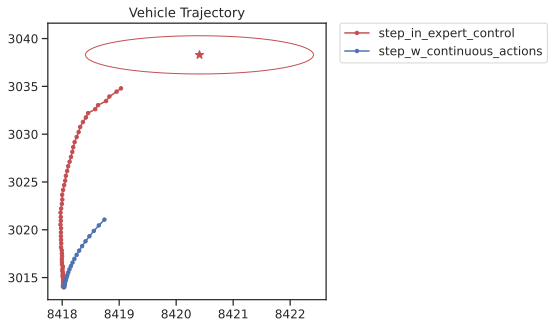

In [113]:
fig, axs = plt.subplots(1, figsize=(5, 5))
axs.plot(pos_arr[:time_step, 0], pos_arr[:time_step, 1], '.-', markersize=7, color='r', label='step_in_expert_control')
axs.plot(pos_arr_cont[:time_step_cont, 0], pos_arr_cont[:time_step_cont, 1], '.-', markersize=7, label='step_w_continuous_actions')
axs.plot(veh_obj.target_position.x, veh_obj.target_position.y, '*', color='r')
target_radius = patches.Circle((veh_obj.target_position.x, veh_obj.target_position.y), facecolor='white', edgecolor='r', radius=2,)
axs.add_patch(target_radius)
axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axs.set_title('Vehicle Trajectory');

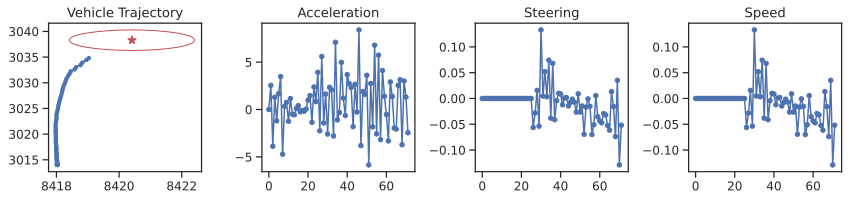

In [115]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

axs[0].plot(pos_arr[:time_step, 0], pos_arr[:time_step, 1], '.-', markersize=7)
axs[0].plot(veh_obj.target_position.x, veh_obj.target_position.y, '*', color='r')
target_radius = patches.Circle((veh_obj.target_position.x, veh_obj.target_position.y), facecolor='white', edgecolor='r', radius=2,)
axs[0].add_patch(target_radius)
axs[0].set_title('Vehicle Trajectory')

axs[1].plot(action_acc[:time_step], '.-')
axs[1].set_title('Acceleration');

axs[2].plot(action_ste[:time_step], '.-')
axs[2].set_title('Steering');

axs[3].plot(action_ste[:time_step], '.-')
axs[3].set_title('Speed')
plt.tight_layout()

In [35]:
df_veh = pd.DataFrame({
    'pos_x': pos_arr[:time_step, 0],
    'pos_y': pos_arr[:time_step, 1],
    'action_acc': action_acc[:time_step],
    'action_ste': action_ste[:time_step],
    'speed': speed_arr[:time_step],
    'steering': steering_arr[:time_step],
})


In [37]:
df_veh.style

,pos_x,pos_y,action_acc,action_ste,speed,steering
0,8412.257812,2969.033936,0.000000,0.000850,13.791367,0.000000
1,8412.227539,2970.370361,3.028097,0.001947,13.367686,0.000000
2,8412.181641,2971.699951,-0.046396,-0.003913,13.303818,0.000000
3,8412.142578,2972.993408,-2.404509,-0.005706,12.940468,0.000000
4,8412.109375,2974.263672,-0.512514,-0.006089,12.706975,0.000000
5,8412.074219,2975.519531,3.142567,-0.011204,12.563514,0.000000
6,8412.037109,2976.756836,-4.423981,0.001172,12.378611,0.000000
7,8412.010742,2977.960693,-7.932386,-0.005309,12.041462,0.000000
8,8411.978516,2979.163330,6.740246,-0.007146,12.030684,0.000000
9,8411.957031,2980.331055,-11.963358,-0.016620,11.679222,0.000000


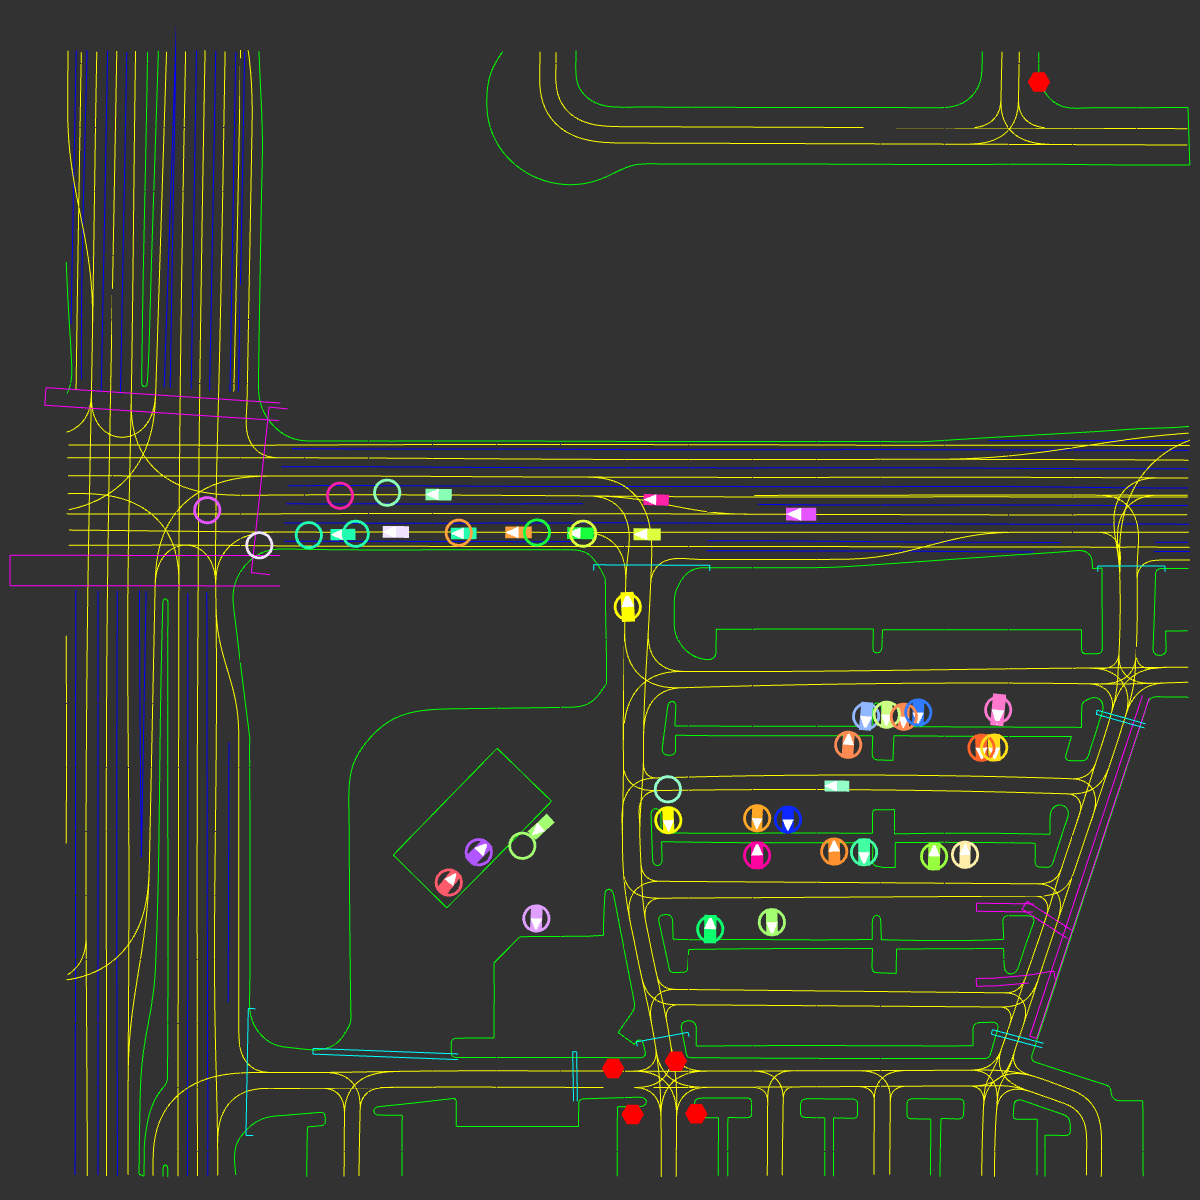

In [83]:
# Path(f"evaluation/videos/{scene_name}").parent.mkdir(parents=True, exist_ok=True)
# create_video(frames, f"evaluation/videos/{scene_name}.gif", fps=4)
# display(HTML(f"<h3>{scene_name}</h3>"))
# display_gif(f"evaluation/videos/{scene_name}.gif")

### 1.4 What is the performance of the BC policy?

- BC model trained to 0.983 % accuracy
- No correction

In [5]:
# # Load trained human reference policy
# BC_MODEL = 'human_policy_S100_01_20_11_22'

# human_policy = load_policy(
#     data_path=BC_BASE_PATH,
#     file_name=BC_MODEL, 
# )

# df_expert_replay = evaluate_policy(
#     env_config=env_config,
#     policy=human_policy,
#     mode='policy',
#     num_scenes=100,
#     max_iters=500,
# )